## 2.5 自动微分

### 2.5.1 一个简单的例子

假设想对函数$y=2x^Tx$关于列向量$x$求导

In [67]:
import torch

x = torch.arange(4.0)
x

tensor([0., 1., 2., 3.])

In [68]:
x.requires_grad_(True)
x.grad

从这里开始定义一个函数

In [69]:
y = 2 * torch.dot(x, x)
y

tensor(28., grad_fn=<MulBackward0>)

In [70]:
y.backward()
x.grad

tensor([ 0.,  4.,  8., 12.])

验证梯度是否正确，也即$y=x^Tx$在$x=[0,1,2,3]^T$的梯度，理论计算应该是$4x$

In [71]:
x.grad == 4 * x

tensor([True, True, True, True])

PyTorch会累计梯度，也就是如果运行两次`.backward()`，就会将两次计算的**梯度相加起来**，故需要清除前面的值

In [72]:
x.grad.zero_()

tensor([0., 0., 0., 0.])

现在计算x的另一个函数，在这里是一个求和函数。
因为$y=x_1+x_2+\cdots+x_n$，根据微分法则有
$$
\frac{dy}{dx_i}=1
$$

In [73]:
y = x.sum()
y.backward()
x.grad

tensor([1., 1., 1., 1.])

### 2.5.2 非标量变量的反向传播

上述的$y$都是一个标量，但当调用向量的反向计算时，我们通常会试图计算一批训练样本中每个组成部分的损失函数的导数。这里，我们的目的不是计算微分矩阵，而是单独计算批量中每个样本的偏导数之和。

需要注意的是，仅仅允许**标量**使用`.backward()`函数，**不允许向量使用**

In [74]:
x.grad.zero_()
y = x * x
# 等价于y.backward(torch.ones(len(x)))
y.sum().backward()
x.grad

tensor([0., 2., 4., 6.])

In [75]:
x.grad == 2 * x

tensor([True, True, True, True])

### 2.5.3 分离计算

也就是将某些计算移动到计算图之外
下面的方向传播函数计算$z=u\cdot x$关于$x$的偏导数，同时将$u$作为常数处理，而不是计算$z=x\cdot x\cdot x$关于$x$的偏导数

In [76]:
x.grad.zero_()
y = x * x
u = y.detach()  # 在这里，u已经作为一个新的向量被分离出来了
z = u * x

z.sum().backward()
x.grad == u

tensor([True, True, True, True])

由于记录了$y$的计算结果，我们可以随后在$y$上调用反向传播， 得到$y=x*x$关于的$x$的导数，即$2*x$

In [77]:
x.grad.zero_()
y.sum().backward()
x.grad == 2 * x

tensor([True, True, True, True])

但是$u$在这里无法对$x$进行求导了，也就是无法调用`u.backward()`

### 2.5.4 Python控制流的梯度计算

Python的条件以及循环控制不会影响梯度计算

In [78]:
def f(a):
    b = a * 2
    while b.norm() < 1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c

In [79]:
a = torch.randn(size=(), requires_grad=True)
d = f(a)
d.backward()
a.grad == d / a

tensor(True)

### 2.5.5 小结

深度学习框架可以自动计算导数：我们首先将梯度附加到想要对其计算偏导数的变量上，然后记录目标值的计算，执行它的反向传播函数，并访问得到的梯度。

### 2.5.6 练习

5. 使$f(x)=\sin(x)$，绘制$f(x)$和$\frac{df(x)}{dx}$的图像，其中后者不使用$f'(x)=\cos(x)$

In [80]:
x_ = torch.arange(0, 2 * torch.pi, 0.01)
x_.requires_grad_(True)
y_ = torch.sin(x_)
y_.sum().backward()

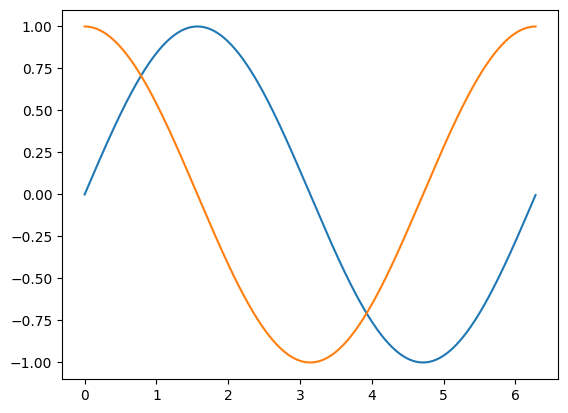

In [81]:
import matplotlib.pyplot as plt

plt.plot(x_.detach().numpy(), y_.detach().numpy(), label='sin(x)')
plt.plot(x_.detach().numpy(), x_.grad.numpy(), label='grad of sin(x)')